# Code to compare compute and time resource cost between cpu and gpu
- uses output from pytorch_test_cpu,gpu.py
- CC node: cedar1
- CC gpu: Tesla P100-PCIE-12GB
- CC CPU: doesn't expose RAPL Package and Core modules






In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns

In [2]:
project_dir = '../'
data_dir = '{}data/'.format(project_dir)
results_dir = '{}results/'.format(project_dir)

In [32]:
def read_flops(f,mode):
    flops_df = pd.read_csv(f)
    flops_df['mode'] = mode
    return flops_df

def read_joules(f,mode):
    joules_df = pd.read_csv(f)
    jcols = joules_df.columns

    regex = re.compile('package_.')
    package_cols = [string for string in jcols if re.match(regex, string)]

    regex = re.compile('dram_.')
    dram_cols = [string for string in jcols if re.match(regex, string)]
    
    joules_df['package_total'] = joules_df[package_cols].sum(axis=1)
    joules_df['dram_total'] = joules_df[dram_cols].sum(axis=1)

    if mode == 'gpu':
        joules_df['nvidia_total'] = joules_df['nvidia_gpu_0']
    else:
        joules_df['nvidia_total'] = 0

    joules_df['process_total'] = joules_df['package_total'] + joules_df['dram_total'] + joules_df['nvidia_total']
    joules_df['mode'] = mode

    return joules_df

In [33]:
experiment_names = ['CC_test_run','CC_test_run_2','CC_test_run_3']
proc_modes = ['cpu','gpu']

jcols = ['experiment_name','mode','duration','package_total','dram_total','nvidia_total','process_total']
flops_df_concat = pd.DataFrame()
joules_df_concat = pd.DataFrame()
for exp_name in experiment_names:
    for proc_mode in proc_modes:
        flops_csv = '{}{}_flops_{}.csv'.format(results_dir,exp_name,proc_mode)
        joules_csv = '{}{}_joules_{}.csv'.format(results_dir,exp_name,proc_mode)
        flops_df = read_flops(flops_csv,proc_mode)
        flops_df['experiment_name'] = exp_name
        joules_df = read_joules(joules_csv,proc_mode)
        joules_df['experiment_name'] = exp_name
        flops_df_concat = flops_df_concat.append(flops_df)
        joules_df_concat = joules_df_concat.append(joules_df[jcols])


flops_df_concat.head()

,Unnamed: 0,epoch,compute_time,brand,cpu_arch,cpu_count,python_version,gpu_device,model,input_size,init_features,n_channels,FLOPs,n_parameters,mode,experiment_name
0,0,0.0,0.202530,Intel(R) Xeon(R) CPU E5-2683 v4 @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),NaN,unet,512,64,1,192.81 GMac,31.04 M,cpu,CC_test_run
1,1,1.0,0.202687,Intel(R) Xeon(R) CPU E5-2683 v4 @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),NaN,unet,512,64,1,192.81 GMac,31.04 M,cpu,CC_test_run
2,2,2.0,0.203021,Intel(R) Xeon(R) CPU E5-2683 v4 @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),NaN,unet,512,64,1,192.81 GMac,31.04 M,cpu,CC_test_run
3,3,3.0,0.219294,Intel(R) Xeon(R) CPU E5-2683 v4 @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),NaN,unet,512,64,1,192.81 GMac,31.04 M,cpu,CC_test_run
4,4,4.0,0.203889,Intel(R) Xeon(R) CPU E5-2683 v4 @ 2.10GHz,X86_64,32,3.7.4.final.0 (64 bit),NaN,unet,512,64,1,192.81 GMac,31.04 M,cpu,CC_test_run


### Plot flops_df

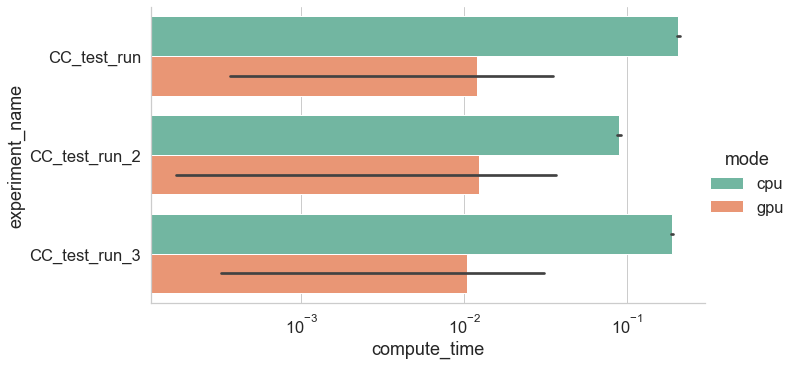

In [40]:
plot_df = flops_df_concat.copy()
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='compute_time', y='experiment_name', hue='mode', kind='bar', data=plot_df, palette='Set2', aspect=2)
    g.set(xscale="log")

### Plot joules_df

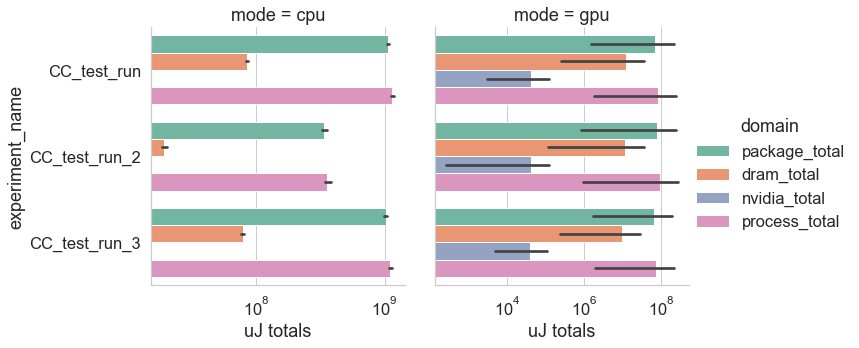

In [37]:
plot_df = joules_df_concat.copy()
plot_df = pd.melt(plot_df, id_vars=['experiment_name','mode','duration'], value_vars=['package_total','dram_total','nvidia_total','process_total'],
 var_name='domain', value_name='uJ totals')
sns.set(font_scale = 1.5)

with sns.axes_style("whitegrid"):
    g = sns.catplot(y='experiment_name',x='uJ totals', hue='domain', col='mode', kind='bar', data=plot_df, palette='Set2',aspect=1, sharex=False)
    g.set(xscale="log")